In [13]:
import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR100
from typing import Optional, Callable
import os
import random
import timm
import numpy as np
import pandas as pd
from torchvision.transforms import v2
from torch.backends import cudnn
from torch import GradScaler
from torch import optim
from tqdm.notebook import tqdm
import time
PATH_FF = 'resnext101_mentormix_70'
os.mkdir(PATH_FF)
from shutil import copy2
copy2("test_mentormix.ipynb", f"{PATH_FF}/source.ipynb")

'resnext101_mentormix_70/source.ipynb'

In [14]:
device = torch.device('cuda')
cudnn.benchmark = True
pin_memory = True
enable_half = True  # Disable for CPU, it is slower!
scaler = GradScaler(device, enabled=enable_half)

In [15]:
class SimpleCachedDataset(Dataset):
    def __init__(self, dataset, include_flipped=False):
        self.include_flipped = include_flipped
        self.data = tuple([x for x in dataset])

    def __len__(self):
        return len(self.data) * (2 if self.include_flipped else 1)

    def __getitem__(self, i):
        if self.include_flipped and i // len(self.data) == 1:
            i = i - len(self.data)
            return (v2.functional.horizontal_flip(self.data[i][0]), self.data[i][1])
        else:
            return self.data[i]

In [16]:
class CIFAR100_noisy_fine(Dataset):
    """
    See https://github.com/UCSC-REAL/cifar-10-100n, https://www.noisylabels.com/ and `Learning with Noisy Labels
    Revisited: A Study Using Real-World Human Annotations`.
    """

    def __init__(
        self, root: str, train: bool, transform: Optional[Callable], download: bool
    ):
        cifar100 = CIFAR100(
            root=root, train=train, transform=transform, download=download
        )
        data, targets = tuple(zip(*cifar100))

        if train:
            noisy_label_file = os.path.join(root, "CIFAR-100-noisy.npz")
            if not os.path.isfile(noisy_label_file):
                raise FileNotFoundError(
                    f"{type(self).__name__} need {noisy_label_file} to be used!"
                )

            noise_file = np.load(noisy_label_file)
            if not np.array_equal(noise_file["clean_label"], targets):
                raise RuntimeError("Clean labels do not match!")
            targets = noise_file["noisy_label"]

        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, i: int):
        return self.data[i], torch.tensor([1. if j == self.targets[i] else 0. for j in range(100)])

In [17]:
basic_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # v2.GaussianNoise(mean=0, sigma=0.005, clip=True),
    # v2.GaussianNoise(mean=0, sigma=0.01, clip=True),
    # v2.GaussianNoise(mean=0, sigma=0.1, clip=True),
    # v2.RandomRotation((-5, 5)),
    # v2.RandomRotation((-15, 15)),
    # v2.RandomRotation((-2, 2)),
    # v2.RandomHorizontalFlip(p=0.5),
    v2.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25), inplace=True)
])
train_set = CIFAR100_noisy_fine('/kaggle/input/fii-atnn-2024-project-noisy-cifar-100/fii-atnn-2024-project-noisy-cifar-100', download=False, train=True, transform=basic_transforms)
test_set = CIFAR100_noisy_fine('/kaggle/input/fii-atnn-2024-project-noisy-cifar-100/fii-atnn-2024-project-noisy-cifar-100', download=False, train=False, transform=basic_transforms)
test_set = SimpleCachedDataset(test_set)

# generator = torch.Generator().manual_seed(42)
# train_set, valid_set = torch.utils.data.random_split(train_set, [0.8, 0.2], generator=generator)
# TODO: Change include flipped for better results
train_loader = DataLoader(SimpleCachedDataset(train_set, include_flipped=False), batch_size=64, shuffle=True, pin_memory=pin_memory)
# valid_loader = DataLoader(SimpleCachedDataset(valid_set, include_flipped=True), batch_size=500, shuffle=False, pin_memory=pin_memory)
test_loader = DataLoader(test_set, batch_size=500, pin_memory=pin_memory)


In [18]:
model = timm.create_model("resnext101_32x8d", pretrained=True) #'hf_hub:grodino/resnet18_cifar10 resnext101_32x8d efficientnet_b5'
model.fc = nn.Sequential(nn.Linear(2048, 100), nn.Softmax(dim=-1))
model = model.to(device)

hist = None
# model = torch.jit.script(model)  # does not work for this model
def custom_cross_entropy_loss(prediction, target, aggregate=True):
    """Modified CrossEntropy to work with fuzzy one-hot encodings. (For mixup targets of type [0.5, 0.5, 0, 0])"""
    losses = (-1 * torch.sum(torch.log(prediction) * target, dim=-1))
    if aggregate:
        return losses.mean()
    else:
        return losses
criterion = custom_cross_entropy_loss # nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.0001, fused=True)

reset_stats = True

In [19]:
def train(mixup=False, mentor=False, weight_again=False, alpha=1, ema_percentile_gamma_p=70):
    """Training loop

    Args:
        mixup (bool, optional): Whether to use mixup. Defaults to False.
        mentor (bool, optional): Whether to use the mentor weighting. `mixup` must be True. Defaults to False.
        weight_again (bool, optional): Whether to reweight mixed up examples. `mentor` must be True. Defaults to False.
        alpha (int, optional): Parameter of the beta distribution for mixup. Defaults to 1.
        ema_percentile_gamma_p (int, optional): Percentile of losses for mentor weighting. Defaults to 70.

    Returns:
        float: Training Loss
    """
    model.train()
    correct = 0
    total = 0
    gamma = 0 # ema
    ema_percentile_gamma_p = ema_percentile_gamma_p # MentorMix -> take x of the minibatch for mixup (most likely to be correctly labeled)
    alpha = alpha # Mixup
    if mixup:
        loaderr = train_loader # zip(train_loader, train_loader)
    else:
        loaderr = train_loader
    with tqdm(loaderr, position=1, leave=False) as mbatch:
        for inputs, targets in mbatch:
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            # Mixup
            if mixup:
                inputs1, targets1 = inputs, targets
                if mentor:
                    losses = criterion(model(inputs), targets, aggregate=False)
                    optimizer.zero_grad()
                    perc_loss = np.percentile(losses.detach().cpu().numpy(), ema_percentile_gamma_p)
                    gamma = gamma * 0.9 + perc_loss * 0.1 # EMA of the admissible loss threshold, so the model doesn't learn from very lossy samples (likely noisy labels)
                    v = nn.functional.softmax((losses < gamma).float(), dim=-1).cpu().float()
                    indexes = random.choices(list(range(inputs.size(0))), weights=v, k=inputs.size(0))
                    inputs2, targets2 = inputs[indexes], targets[indexes]
                    lam = np.random.beta(alpha, alpha)
                    inputs = inputs1 * lam + inputs2 * (1 - lam)
                    targets = targets1 * lam + targets2 * (1 - lam)
                    optimizer.zero_grad()
                else:
                    indexes = torch.randperm(inputs.size(0))
                    inputs2, targets2 = inputs[indexes], targets[indexes]
                    lam = np.random.beta(alpha, alpha)
                    inputs = inputs1 * lam + inputs2 * (1 - lam)
                    targets = targets1 * lam + targets2 * (1 - lam)
            with torch.autocast(device.type, enabled=enable_half):
                outputs = model(inputs)
                # print(outputs.shape)
                loss = criterion(outputs, targets, aggregate=True)
                # Weight again
                if mentor and weight_again:
                    loss *= (loss < gamma).float().detach()
                    loss = loss.mean()
                    mbatch.set_postfix_str(f"{gamma:.4f} taken: {int((losses < gamma).float().sum().item()):>3} / {int(loss.shape[0])}")
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            predicted = outputs.argmax(1)
            ts = targets.argmax(1)
            total += targets.size(0)
            correct += predicted.eq(ts).sum().item()

    return 100.0 * correct / total

In [20]:
@torch.inference_mode()
def val(loader):
    model.eval()
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        with torch.autocast(device.type, enabled=enable_half):
            outputs = model(inputs)

        predicted = outputs.argmax(1)
        ts = targets.argmax(1)
        total += targets.size(0)
        correct += predicted.eq(ts).sum().item()

    return 100.0 * correct / total

In [21]:
@torch.inference_mode()
def inference():
    model.eval()

    labels = []

    for inputs, _ in test_loader:
        inputs = inputs.to(device, non_blocking=True)
        with torch.autocast(device.type, enabled=enable_half):
            outputs = model(inputs)

        predicted = outputs.argmax(1).tolist()
        labels.extend(predicted)

    return labels

In [12]:
best = 0.0
best_idx = 0
epochs = list(range(1000))
if reset_stats:
    reset_stats = False
    # To be able to continue training and preserve the history of the model.
    hist = []
    hist_gpu = []
    elapsed = 0
with tqdm(epochs) as tbar:
    for idx, epoch in enumerate(tbar):
        t = time.time()
        train_acc = train(mixup=True, mentor=True, weight_again=False, alpha=1, ema_percentile_gamma_p=70)
        val_acc = val(test_loader)
        t -= time.time()
        hist.append((train_acc, val_acc, -t))
        hist_gpu.append(torch.cuda.memory_stats())
        if val_acc > best:
            best = val_acc
            best_idx = idx
            torch.save(model.state_dict(), open(f"{PATH_FF}/model.pt", "wb"))
        if idx - best_idx > 10:
            break
        tbar.set_description(f"Train: {train_acc:.2f}, Val: {val_acc:.2f}, Best: {best:.2f}")
    elapsed += tbar.format_dict['elapsed']

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

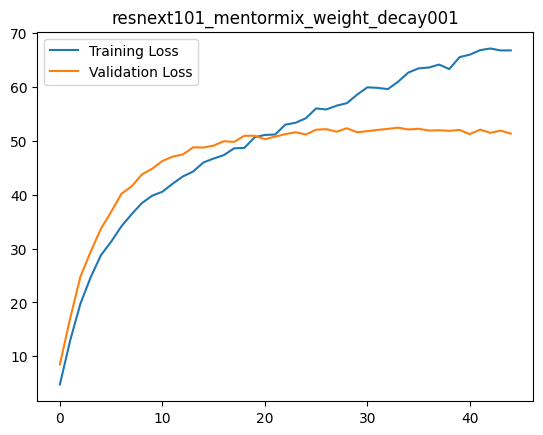

C:\Users\KebabWarrior\AppData\Local\Temp\ipykernel_11076\2054969833.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{PATH_FF}/model.p

52.47


In [134]:
import matplotlib.pyplot as plt
import json
trains, valids, ts = zip(*hist)
plt.title(PATH_FF)
plt.plot(trains, label="Training Loss")
plt.plot(valids, label="Validation Loss")
plt.legend()
plt.savefig(f"{PATH_FF}/hist.png")
plt.show()
model.load_state_dict(torch.load(f"{PATH_FF}/model.pt"))
best_val = val(test_loader)
print(val(test_loader))
model.train()
json.dump({"elapsed": elapsed,
           "best_acc": best_val,
           "nparam": sum(p.numel() for p in model.parameters()),
           "nparam_trainable": sum(p.numel() for p in model.parameters() if p.requires_grad),
           "loss": hist,
           "gpu": hist_gpu,
          }, open(f"{PATH_FF}/stats.json", "wt"))

In [135]:
data = {
    "ID": [],
    "target": []
}

for i, label in enumerate(inference()):
    data["ID"].append(i)
    data["target"].append(label)

df = pd.DataFrame(data)
df.to_csv(f"{PATH_FF}/submission.csv", index=False)